# Voting Records Association Rules
Iman Anwarzai, Machine Learning 2020

In [1]:
!pip install mlxtend

In [1]:
import pandas as pd
import numpy as np
import mlxtend
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
%matplotlib inline

The dataset I am using is from http://archive.ics.uci.edu/ml/datasets/congressional+voting+records.  It depicts the voting records for the 435 members of the US House of Representatives on 16 key issues in 1984.

In [2]:
data_file = "../../ml_datasets/house-votes-84.data" 

In [3]:
data = pd.read_csv(data_file, header = None) 
  
# adding column headings 
data.columns = ['party', 'handicapped-infants', 'water-project', 'budget-resolution', 
               'physician-fee-freeze', 'el-salvador-aid', 'religion-in-schools', 'anti-sat-ban',
               'nicaraguan-contras', 'mx-missile', 'immigration', 'synfuels-cutback',
               'education-spending', 'superfund-sue', 'crime', 'duty-free-exports', 
               'admin-act-sa'] 

This is the attribute information given:
   1. Class Name: 2 (democrat, republican)
   2. handicapped-infants: 2 (y,n)
   3. water-project-cost-sharing: 2 (y,n) --> renamed "water-project"
   4. adoption-of-the-budget-resolution: 2 (y,n) --> renamed "budget-resolution"
   5. physician-fee-freeze: 2 (y,n)
   6. el-salvador-aid: 2 (y,n)
   7. religious-groups-in-schools: 2 (y,n) --> renamed "religion-in-school"
   8. anti-satellite-test-ban: 2 (y,n) --> renamed "anti-sat-ban"
   9. aid-to-nicaraguan-contras: 2 (y,n) --> renamed "nicaraguan-contras"
   10. mx-missile: 2 (y,n) 
   11. immigration: 2 (y,n)
   12. synfuels-corporation-cutback: 2 (y,n) --> renamed "synfuels-cutback"
   13. education-spending: 2 (y,n)
   14. superfund-right-to-sue: 2 (y,n) --> renamed "superfund sue"
   15. crime: 2 (y,n)
   16. duty-free-exports: 2 (y,n)
   17. export-administration-act-south-africa: 2 (y,n) --> remamed "admin-act-sa"
   
We can see the raw data (below) has a y/n format along with question marks which depict unknown values.  Each row represents a member of the House of Representatives.  Each member is a "transaction," while the issues they vote on (and against) are items.

In [4]:
data

,party,handicapped-infants,water-project,budget-resolution,physician-fee-freeze,el-salvador-aid,religion-in-schools,anti-sat-ban,nicaraguan-contras,mx-missile,immigration,synfuels-cutback,education-spending,superfund-sue,crime,duty-free-exports,admin-act-sa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?
2,democrat,?,y,y,?,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,?,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,?,y,y,y,y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,republican,n,n,y,y,y,y,n,n,y,y,n,y,y,y,n,y
431,democrat,n,n,y,n,n,n,y,y,y,y,n,n,n,n,n,y
432,republican,n,?,n,y,y,y,n,n,n,n,y,y,y,y,n,y
433,republican,n,n,n,y,y,y,?,?,?,?,n,y,y,y,n,y


In [5]:
# one hot encoding for the party column
data['republican'] = (data['party'] == 'republican').astype(int)
data['democrat'] = (data['party'] == 'democrat').astype(int)
del data['party']

The output below is our data that is ready to be put into the apriori algorithm.  Notice that we doubled the number of columns - each issue can be voted for or against.  If a congressman explictly voted against something (that is, they are not listed as ?), then the against vote is in their transaction.  I also made two new columns for the different parties, so being a democrat or being a republican is also an item.

In [6]:
for (col) in data: 
    #print(col)
    if(col!='republican' and col!='democrat') :
        data['no-' + col] = (data[col] == 'n').astype(int)
        data[col] = (data[col] == 'y').astype(int)
data

,handicapped-infants,water-project,budget-resolution,physician-fee-freeze,el-salvador-aid,religion-in-schools,anti-sat-ban,nicaraguan-contras,mx-missile,immigration,...,no-anti-sat-ban,no-nicaraguan-contras,no-mx-missile,no-immigration,no-synfuels-cutback,no-education-spending,no-superfund-sue,no-crime,no-duty-free-exports,no-admin-act-sa
0,0,1,0,1,1,1,0,0,0,1,...,1,1,1,0,0,0,0,0,1,0
1,0,1,0,1,1,1,0,0,0,0,...,1,1,1,1,1,0,0,0,1,0
2,0,1,1,0,1,1,0,0,0,0,...,1,1,1,1,0,1,0,0,1,1
3,0,1,1,0,0,1,0,0,0,0,...,1,1,1,1,0,1,0,1,1,0
4,1,1,1,0,1,1,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,0,0,1,1,1,1,0,0,1,1,...,1,1,0,0,1,0,0,0,1,0
431,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,1,1,1,1,1,0
432,0,0,0,1,1,1,0,0,0,0,...,1,1,1,1,0,0,0,0,1,0
433,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [7]:
data.columns

Index(['handicapped-infants', 'water-project', 'budget-resolution',
       'physician-fee-freeze', 'el-salvador-aid', 'religion-in-schools',
       'anti-sat-ban', 'nicaraguan-contras', 'mx-missile', 'immigration',
       'synfuels-cutback', 'education-spending', 'superfund-sue', 'crime',
       'duty-free-exports', 'admin-act-sa', 'republican', 'democrat',
       'no-handicapped-infants', 'no-water-project', 'no-budget-resolution',
       'no-physician-fee-freeze', 'no-el-salvador-aid',
       'no-religion-in-schools', 'no-anti-sat-ban', 'no-nicaraguan-contras',
       'no-mx-missile', 'no-immigration', 'no-synfuels-cutback',
       'no-education-spending', 'no-superfund-sue', 'no-crime',
       'no-duty-free-exports', 'no-admin-act-sa'],
      dtype='object')

In [8]:
freq_items = apriori(data, min_support=0.4, use_colnames=True, verbose=1)
freq_items

Processing 6 combinations | Sampling itemset size 6


,support,itemsets
0,0.429885,(handicapped-infants)
1,0.448276,(water-project)
2,0.581609,(budget-resolution)
3,0.406897,(physician-fee-freeze)
4,0.487356,(el-salvador-aid)
...,...,...
113,0.439080,"(no-physician-fee-freeze, no-el-salvador-aid, ..."
114,0.413793,"(no-education-spending, no-physician-fee-freez..."
115,0.400000,"(anti-sat-ban, no-physician-fee-freeze, budget..."
116,0.411494,"(no-physician-fee-freeze, no-el-salvador-aid, ..."


In [192]:
rules = association_rules(freq_items, metric="confidence", min_threshold=0.7)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(anti-sat-ban),(budget-resolution),0.549425,0.581609,0.462069,0.841004,1.445995,0.142518,2.631458
1,(budget-resolution),(anti-sat-ban),0.581609,0.549425,0.462069,0.794466,1.445995,0.142518,2.192219
2,(budget-resolution),(nicaraguan-contras),0.581609,0.556322,0.494253,0.849802,1.527537,0.170691,2.953962
3,(nicaraguan-contras),(budget-resolution),0.556322,0.581609,0.494253,0.888430,1.527537,0.170691,3.750021
4,(mx-missile),(budget-resolution),0.475862,0.581609,0.413793,0.869565,1.495102,0.137027,3.207663
...,...,...,...,...,...,...,...,...,...
533,"(democrat, nicaraguan-contras)","(anti-sat-ban, no-physician-fee-freeze, no-el-...",0.501149,0.409195,0.400000,0.798165,1.950572,0.194932,2.927168
534,(anti-sat-ban),"(no-physician-fee-freeze, democrat, no-el-salv...",0.549425,0.439080,0.400000,0.728033,1.658087,0.158758,2.062458
535,(no-physician-fee-freeze),"(anti-sat-ban, no-el-salvador-aid, democrat, n...",0.567816,0.411494,0.400000,0.704453,1.711940,0.166347,1.991245
536,(no-el-salvador-aid),"(anti-sat-ban, no-physician-fee-freeze, democr...",0.478161,0.422989,0.400000,0.836538,1.977686,0.197743,3.529953


<b>Support:</b> How frequently the rule appears in the data.
<br>
<b>Confidence:</b> How frequently the antecedent occurs among all the rows containing the consequent (how reliable this rule is).
<br>
<b>Lift:</b> Measures how many times more often antecedent and consequent occur together than expected if they were statistically independent.
<br>
<b>Leverage:</b> Measures the difference of antecedent and consequent appearing together in the data set and what would be expected if antecedent and consequent were statistically dependent.
<br>
<b>Conviction:</b> Conviction compares the probability that antecedent appears without consequent if they were dependent with the actual frequency of the appearance of antecedent without consequent.
<br>

Confidence and conviction are directed, while support, lift, and leverage are not.

Using the mlxtend methods, we have created association rules for the votes.  I increased the min_support for apriori and min_threshold (confidence) for association_rules in order to get a good number of rules.  With their original values of 0.2 and 0.6 respectively, I had ended up with tens of thousands of rules with lower confidence and minimal support.

We are now ready to visualize these rules' metrics with matplotlib.

## Visualizing results
### Support vs Confidence

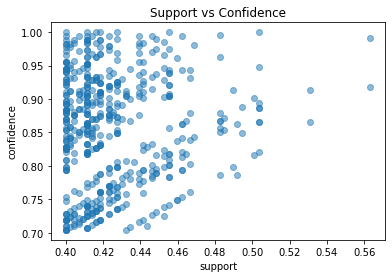

In [11]:
plt.scatter(rules['support'], rules['confidence'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('confidence')
plt.title('Support vs Confidence')
plt.show()

### Support vs Lift

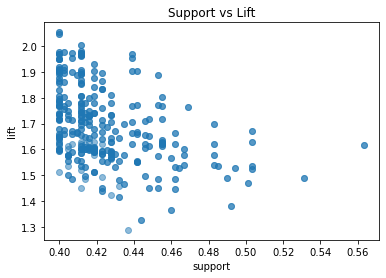

In [12]:
plt.scatter(rules['support'], rules['lift'], alpha=0.5)
plt.xlabel('support')
plt.ylabel('lift')
plt.title('Support vs Lift')
plt.show()

### Lift vs Confidence

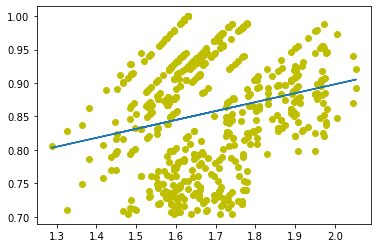

In [13]:
fit = np.polyfit(rules['lift'], rules['confidence'], 1)
fit_fn = np.poly1d(fit)
plt.plot(rules['lift'], rules['confidence'], 'yo', rules['lift'], 
 fit_fn(rules['lift']))

The below algorithm uses networkxto draw a directed graph with the rules in this notebook.  Each rule antecedent is connected to a rule number, which is then connected to the consequent.  This way, if rules have multiple antecedents/consequents, this can be accounted for.

In this graph, we only show 50 rules.

In [230]:
def draw_graph(rules, rules_to_show):
  import networkx as nx  
  G1 = nx.DiGraph()
   
  color_map=[]
  N = 50
  colors = np.random.rand(N)
  strs = []
  for i in range(rules_to_show):  
      strs += ['R' + str(i)]   
   
  for i in range (rules_to_show):      
    G1.add_nodes_from(["R"+str(i)])
     
    for a in rules.iloc[i]['antecedents']:
        G1.add_nodes_from([a])
        G1.add_edge(a, "R"+str(i), color=colors[i] , weight = 2)
       
    for c in rules.iloc[i]['consequents']:
            G1.add_nodes_from([c])
            G1.add_edge("R"+str(i), c, color=colors[i],  weight=2)
 
  for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')    
  edges = G1.edges()
  colors = [G1[u][v]['color'] for u,v in edges]
  weights = [G1[u][v]['weight'] for u,v in edges]
 
  pos = nx.spring_layout(G1, k=16, scale=1)
  nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            
   
  for p in pos:  # raise text positions
           pos[p][1] += 0.07
  nx.draw_networkx_labels(G1, pos)
  plt.show()
  return G1

In [231]:
support=rules['support'].to_numpy()
confidence=rules['confidence'].to_numpy()
 
import seaborn as sns1 

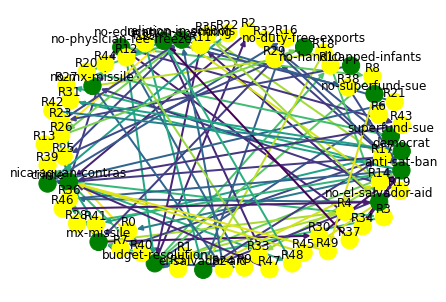

In [232]:
plt.gcf().clear()
G = draw_graph (rules, 50) 

Since the 50 rules we selected only have one antecedent mapped to one consequent (still above threshold high support/confidence), we can just get rid of the rule nodes and picture how individual items are connected to one another.

In [225]:
sankey_support = []
sankey_lift = []
sankey_lev = []

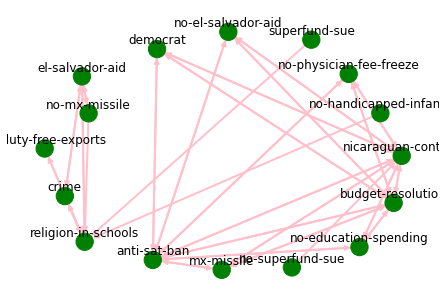

In [227]:
def draw_graph_without_r(rules, rules_to_show):
    global sankey_support
    global sankey_lift
    global sankey_lev
    import networkx as nx  
    G1 = nx.DiGraph()
    color_map=[]
    N = 50
    colors = np.random.rand(N) 
    strs = []
    for i in range(rules_to_show):  
      strs += ['R' + str(i)]  
    nodes_list = np.array(data.columns)
    for index, row in rules[:rules_to_show].iterrows():
        G1.add_node(list(row['antecedents'])[0])   
        G1.add_node(list(row['consequents'])[0]) 
        G1.add_edge(list(row['antecedents'])[0], list(row['consequents'])[0], color="pink",  weight=2)
        sankey_support += [row['support']]
        sankey_lift += [row['lift']]
        sankey_lev += [row['leverage']]

    for node in G1:
       found_a_string = False
       for item in strs: 
           if node==item:
                found_a_string = True
       if found_a_string:
            color_map.append('yellow')
       else:
            color_map.append('green')    
    edges = G1.edges()
    colors = [G1[u][v]['color'] for u,v in edges]
    weights = [G1[u][v]['weight'] for u,v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)
    nx.draw(G1, pos, edges=edges, node_color = color_map, edge_color=colors, width=weights, font_size=16, with_labels=False)            

    for p in pos:  # raise text positions
           pos[p][1] += 0.07
    nx.draw_networkx_labels(G1, pos)
    plt.show()
    return G1

plt.gcf().clear()
G2 = draw_graph_without_r (rules, 50) 

Still, there are better ways to visualize this information.  In the next few cells, I am going through a series of data preprocessings to prepare the data for three different web visualizations in d3: a force diagram, a correlogram, and a sankey diagram.  Source + inspiration: https://www.d3-graph-gallery.com/.

In [206]:
import json

from networkx.readwrite import json_graph
for n in G:
    G.nodes[n]["name"] = n
d = json_graph.node_link_data(G)
json.dump(d, open('force.json','w'))
print("Wrote node-link JSON data to force.json")

rules[:50].to_json (r'rules.json')
print("Wrote rules JSON data to rules.json")

Wrote node-link JSON data to force.json
Wrote rules JSON data to rules.json


In [207]:
len(list(G2.edges))

50

In [228]:
for n in G2:
    G2.nodes[n]["name"] = n
dn = {"node": np.arange(len(list(G2.nodes()))), "name": np.array(list(G2.nodes()))}
nodes_df = pd.DataFrame(dn, columns=["node", "name"])
links_df = pd.DataFrame(np.array(list(G2.edges)))
links_df.columns = ["source", "target"]
links_df["value"] = sankey_support
links_df["lift"] = sankey_lift
links_df["lev"] = sankey_lev
links_df["source"] = links_df["source"].map(nodes_df.set_index('name')['node'])
links_df["target"] = links_df["target"].map(nodes_df.set_index('name')['node'])
#print(links_df)
for i, r1 in links_df.iterrows():
    for j, r2 in links_df.iterrows():
        if r1["source"] == r2["target"] and r1["target"] == r2["source"] and i < j:
            #print(j)
            links_df = links_df.drop(j)

nodeslist = {"nodes": list(nodes_df['name'])}
#print(nodeslist)
json.dump(nodeslist, open('nodes.json','w'))
print("Wrote nodes JSON data to nodes.json")

#print(links_df)
dn = nodes_df.to_dict(orient='records')
dl = links_df.to_dict(orient='records')

final_json = {"nodes": dn, "links": dl}

json.dump(final_json, open('sankey.json','w'))
#with open('sankey/sankey.json', 'w', encoding="ascii", newline='\r\n') as outfile:
#    json.dump(final_json, outfile, indent=4)
print("Wrote node-link JSON data to sankey.json")

Wrote nodes JSON data to nodes.json
Wrote node-link JSON data to sankey.json


In [186]:
import csv
rules["antecedents"] = rules["antecedents"].apply(lambda x: list(x)[0]).astype("unicode")
rules["consequents"] = rules["consequents"].apply(lambda x: list(x)[0]).astype("unicode")

In [234]:
r = rules[:50]
cols = np.append(list(r['antecedents']), list(r['consequents']))
cols = list(set(cols))
corr_df = pd.DataFrame(columns=(np.append(["labels"], cols)))
corr_df['labels'] = cols
for i, r1 in r.iterrows():
    col = r1['antecedents']
    row = r1['consequents']
    corr_df.at[cols.index(row), col] = r1['support']
corr_df = corr_df.fillna(0)
corr_df = corr_df.rename(columns={"labels": ""})

corr_df.to_csv(r'corr.csv', quoting=csv.QUOTE_NONNUMERIC, index=False)
print("Wrote rules csv data corr.csv")

Wrote rules csv data corr.csv


## NOTE
This temporary server was used during development, but isn't properly set up with my files.  The best way to view the visualizations is to copy the "ml_final_web" folder (in this repository) and host it using a local server (I used XAMPP).  All the JSON files/CSV are already in this folder.

In [31]:
import flask

# Serve the file over http to allow for cross origin requests
app = flask.Flask(__name__, static_folder="sankey")


@app.route("/")
def static_proxy():
    return app.send_static_file("sankey.html")


print("\nGo to http://localhost:8080 to see the example\n")
app.run(port=8080)


Go to http://localhost:8080 to see the example

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8080/ (Press CTRL+C to quit)
127.0.0.1 - - [09/Dec/2020 23:02:51] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 23:02:52] "GET /sankey/sankey.json HTTP/1.1" 200 -
127.0.0.1 - - [09/Dec/2020 23:02:52] "GET /favicon.ico HTTP/1.1" 404 -


## Video
(will be remade soon)